model.py

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input   Layer
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv("drive/MyDrive/Forest Cover Classification/cover_data.csv")
feature = df.iloc[:, : -1]
labels = df.iloc[:, -1]
features_train, features_test, labels_train, labels_test = train_test_split(
    feature, 
    labels, 
    test_size = 0.2,
    random_state = 42,
    stratify = labels
)
scaler = StandardScaler()

features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

def design_model(learning_rate):

    model = Sequential()
    # Set the input layer:
    model.add(InputLayer(input_shape = (features_train_scaled.shape[1],)))
    
    # Set the hidden layers:
    model.add(Dense(256, activation = "relu"))
    model.add(Dense(128, activation = "relu"))
    #model.add(Dropout(0.1))
    model.add(Dense(64, activation = "relu"))
    model.add(Dense(32, activation = "relu"))
    model.add(Dense(16, activation = "relu"))
    model.add(Dense(8, activation = "relu"))
    # Set the output layer:
    model.add(Dense(8, activation = "softmax"))
    opt = Adam(learning_rate = learning_rate)
    model.compile(
        loss = "sparse_categorical_crossentropy",  
        metrics = ["accuracy"], 
        optimizer = opt
    )

    model.summary()
    return model

def fit_model(learning_rate, num_epochs, batch_size):
    model = design_model(learning_rate)
    stop = EarlyStopping(
        monitor = "val_accuracy", 
        mode = "auto",
        verbose = 1, 
        patience = 10 
    )
    history = model.fit(
        features_train,
        labels_train,
        epochs = num_epochs,
        batch_size = batch_size,
        verbose = 1,
        validation_split = 0.1,        #  10% of the data would be allocated for validation
        callbacks = [stop]
    )
    return history, features_test, labels_test

visualize.py

In [6]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_accuracy(history):
    # Plot accuracy
    fig = plt.figure(figsize = (15,10))
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'validation'], loc='upper left')
    
    # Plot loss and val_loss over each epoch
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('plot learning curves')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'validation'], loc='upper left') 
    fig.tight_layout()

def plot_heatmap(class_names, y_pred, y_test):
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(15, 15))
    heatmap = sns.heatmap(cm, fmt='g', cmap='Blues', annot=True, ax=ax)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)
    # Save the heatmap to file
    heatmapfig = heatmap.get_figure()
    #heatmapfig.savefig(f'../output/confusion_matrix.png')

report.py

In [7]:
from sklearn.metrics import classification_report
import numpy as np

class_names = ['Spruce/Fir', 'Lodgepole Pine',
                   'Ponderosa Pine', 'Cottonwood/Willow',
                   'Aspen', 'Douglas-fir', 'Krummholz']

def report(model, features_test, labels_test):
    score = model.evaluate(features_test, labels_test, verbose = 0)
    print(f'Test loss: {score[0]}')
    print(f'Test accuracy: {score[1]}')

    # evaluating the model:
    y_pred = model.predict(features_test)
    # Convert the pred to discrete values
    y_pred = np.argmax(y_pred, axis=1)
    print(classification_report(labels_test, y_pred, target_names = class_names))

    return y_pred

script.py

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               14080     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_12 (Dense)             (None, 8)                

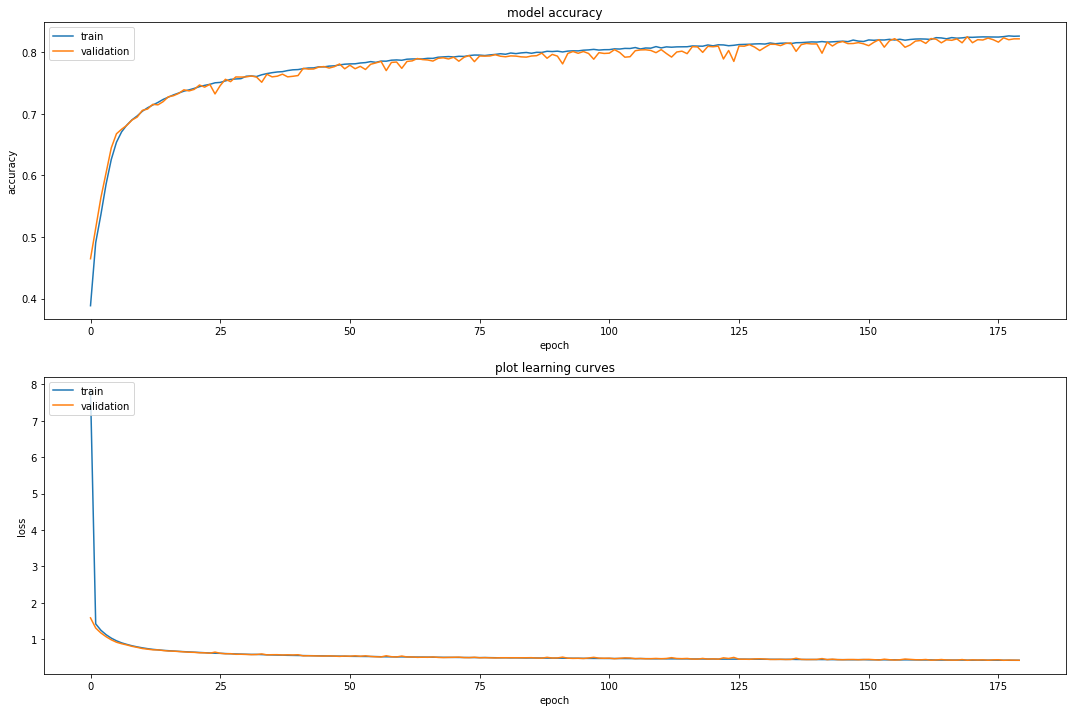

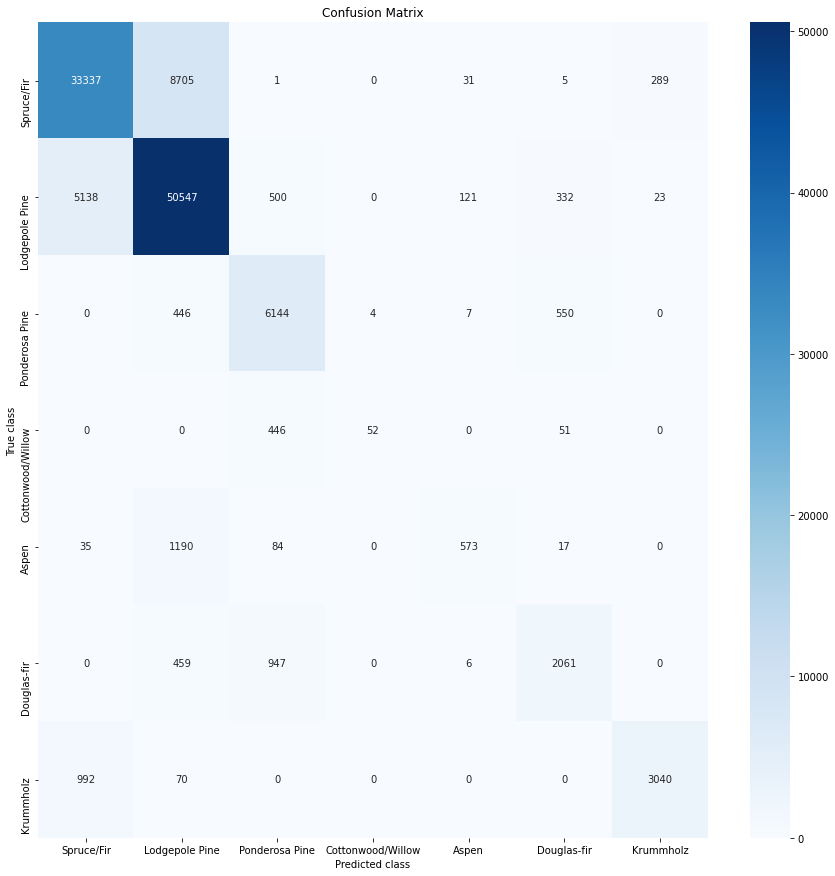

In [8]:
import pprint
# from model import fit_model
# from visualize import plot_accuracy, plot_heatmap
# from report import class_names, report

learning_rate = 0.00005
# Too many epochs can lead to overfitting, and too few to underfitting. 
num_epochs = 200
batch_size = 1024

history, features_test, labels_test = fit_model(learning_rate, num_epochs, batch_size)
#pprint.pprint(history.__dict__)
#pprint.pprint(history.model.__dict__)

plot_accuracy(history)

y_pred = report(history.model, features_test, labels_test)

plot_heatmap(class_names, y_pred, labels_test)